title: High Level Business Metrics - User Discovery
<br>
date: 2021-10-15
<br>
region: US
<br>
author: Henry Xu
<br>
tags: user discovery, user study, business metrics, funding, fund inflow, fund outflow, MAU, card spend, account closure
<br>
summary: This high level research looks at some of the business metrics on our current users related to funding, spending, MAU and account closure. 
Subsequent studies with deep dive will be followed.

In [4]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### App Opens Time Series

In [6]:
from datalib import database
from utils import setup

db = database.Database("redshiftreader", setup.config_file, setup.vault_section)
db.create_engine(sslmode="require")

with db.engine.begin() as conn:
    app_open = db.df_from_sql(
        """
            select 
                case 
                    when kec.platform = -1 then 'Web'
                    when kec.platform = 0 then 'Other'
                    when kec.platform = 1 then 'Android'
                    else 'IOS'
                end as platform,
                dd.week_end::date,
                count(kec.event_id) / count(distinct kec.user_id)::float as avg_app_open
            from etl_reporting.ksp_event_core kec 
            inner join etl_reporting.ksp_event_types ket 
                on kec.event_type = ket.event_type 
            inner join etl_reporting.ksp_ip_geo kig 
                on kec.event_id = kig.event_id 
            inner join dbt.dim_dates dd 
                on dd."date" = kec.collector_tstamp ::date
            where 1 = 1
                and kig.country = 'US'
                and ket.se_category = 'authentication'
                and ket.se_action = 'login'
                and kec.collector_tstamp >= '2021-01-01'
                and dd.week_end < date_trunc('week', current_date) 
            group by 1,2
            order by 1,2
            """,
        connection=conn,
    )

In [7]:
app_open["avg_app_open"] = round(app_open["avg_app_open"], 2)

In [59]:
## Manually inserting two data points as this is easiest way to represent on graph
## rationale: after exploring the database IOS is missing tracking for these 2 weeks

x = pd.DataFrame(
    [
        {"platform": "IOS", "week_end": "2021-02-07", "avg_app_open": 0.0},
        {"platform": "IOS", "week_end": "2021-02-14", "avg_app_open": 0.0},
    ]
)

In [16]:
df2 = pd.concat([df.iloc[:46], x, df.iloc[46:]]).reset_index(drop=True)

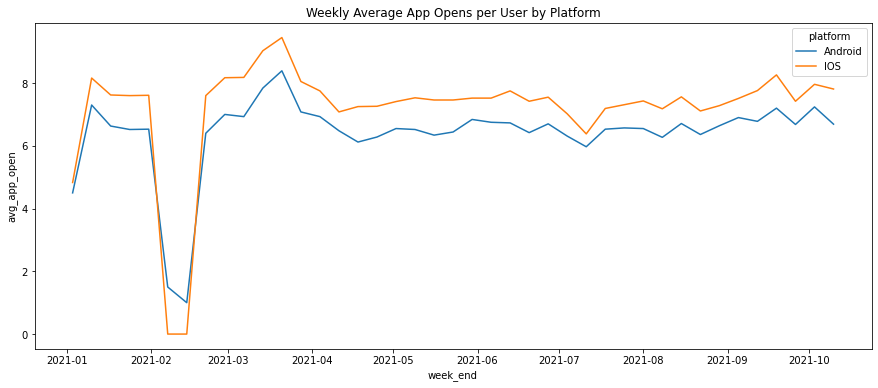

In [19]:
## Plot line graph

plt.figure(figsize=(15, 6))
sns.lineplot(x="week_end", y="avg_app_open", hue="platform", data=df2)
plt.title("Weekly Average App Opens per User by Platform")
plt.show()

Observations:
>    1. IOS users always open apps more often than Android users. 
>    2. The drop in first two weeks of February is due to pausing snowplow tracking.

### WAU/MAU

The link to query on Metabase which shows the count of WAU, the count of MAU and the percentage of WAU/MAU over time:
<br>
https://metabase-main.tech26.us/question/873-ratio-of-wau-to-mau

Observation:
> 1. Percentage of WAU out of MAU is consistently between 70% and 75%

### Funding Inflow by Week and Source

The link to the dashobard on FT Funding counts, total transaction amount, average transaction amount and percentage:
<br>    https://metabase-main.tech26.us/dashboard/97-account-funding-first-time-funding-by-type?date_filter=past1years~

The link to the dashobard on Funding per period counts, total transaction amount, average transaction amount and percentage:
<br> https://metabase-main.tech26.us/dashboard/188-account-funding-all-time

Observations:
> For the year of 2021
> 1. ACH, OCT and Top Up are the 3 most popular FT funding source in terms of transaction counts.
> 2. ACH generally has the highest average FT funding amount per user.
> 3. OCT has been increasing as percentage of total FT Funding transaction counts.
> 4. OCT is the most popular funding source in terms of transaction counts.
> 5. ACH has the highest average funding amount per user until mid July, and then Direct Deposit took over as the highest.


### Funding Outflow by Week and Source

The link to the dashobard of Funding Outflow on counts, total transaction amount, average transaction amount and percentage:
<br> https://metabase-main.tech26.us/dashboard/189-account-funding-outflow?date_filter=thisyear&period=week

Observations:
> 1. Card spend is the highest in terms of transaction counts and total dollar amount, followed by ATM and AFT transactions.
> 2. Card spend is the highest in terms of average transaction count per user.

#### Card Spend Details

The breakdown of card spend by categories is present on the Funding Outflow Dashboard. 
<br>Top 10 categories are shown for total spend and average spend per user:
<br>https://metabase-main.tech26.us/dashboard/189-account-funding-outflow?date_filter=thisyear&period=week

Observations:
> 1. Grocery, Restaurant, and Service Station (Gas Station) are the top 3 spending by total amount throughout 2021.
> 2. When looking at average spend per user we can find that top spedning categories are car/truck related (sales/service/repair), wires/money orders, local travel related (house rental/car rental) and betting/casino gambling.


### Account Balance by Week

The link to query on Average Daily Ending Balance by Week and Percentage of Negative Balance:
<br> https://metabase-main.tech26.us/question/1269-negative-daily-balance-as-of-total-daily-balance
<br>
The link to query on Average Daily Ending Balance per User by Week:
<br> https://metabase-main.tech26.us/question/1924-average-ending-balance-per-user

Observations:
> 1. Average daily ending balance has been decreasing since mid March, but percentage of negative balance has been under the goal max percentage.
> 2. Average daily ending balance per user has been relatively stable and increasing since July.

#### Distribution of current account balance at user level

In [60]:
## Retrieve data

from datalib import database
from utils import setup

db = database.Database("redshiftreader", setup.config_file, setup.vault_section)
db.create_engine(sslmode="require")

with db.engine.begin() as conn:
    acct_balance = db.df_from_sql(
        """
            select
                da.user_id,
                sum(b.bank_balance_cents)/100::float as current_balance
            from au_bank_balances b
            join dbt.dim_accounts da on da.account_id = b.account_id
            where da.status = 'OPEN'
            group by 1
            """,
        connection=conn,
    )

In [67]:
## Define groups of balance bound to calculate percentage of each group

group = np.empty(len(acct_balance["current_balance"]), dtype=object)

group[acct_balance["current_balance"] == 0] = "0"
group[
    (acct_balance["current_balance"] >= 1) & (acct_balance["current_balance"] < 20)
] = "1 to 20"
group[
    (acct_balance["current_balance"] >= 20) & (acct_balance["current_balance"] < 100)
] = "20 to 100"
group[
    (acct_balance["current_balance"] >= 100) & (acct_balance["current_balance"] < 2000)
] = "100 to 2000"
group[acct_balance["current_balance"] >= 2000] = "over 2000"

acct_balance["group"] = group
ab = acct_balance["group"].value_counts(normalize=True)

In [68]:
abb = pd.DataFrame(ab.rename("percentage").reset_index())
abb.rename(columns={"index": "group"}, inplace=True)
abb

,group,percentage
0,1 to 20,0.597878
1,100 to 2000,0.151397
2,20 to 100,0.148332
3,0,0.079917
4,over 2000,0.022476


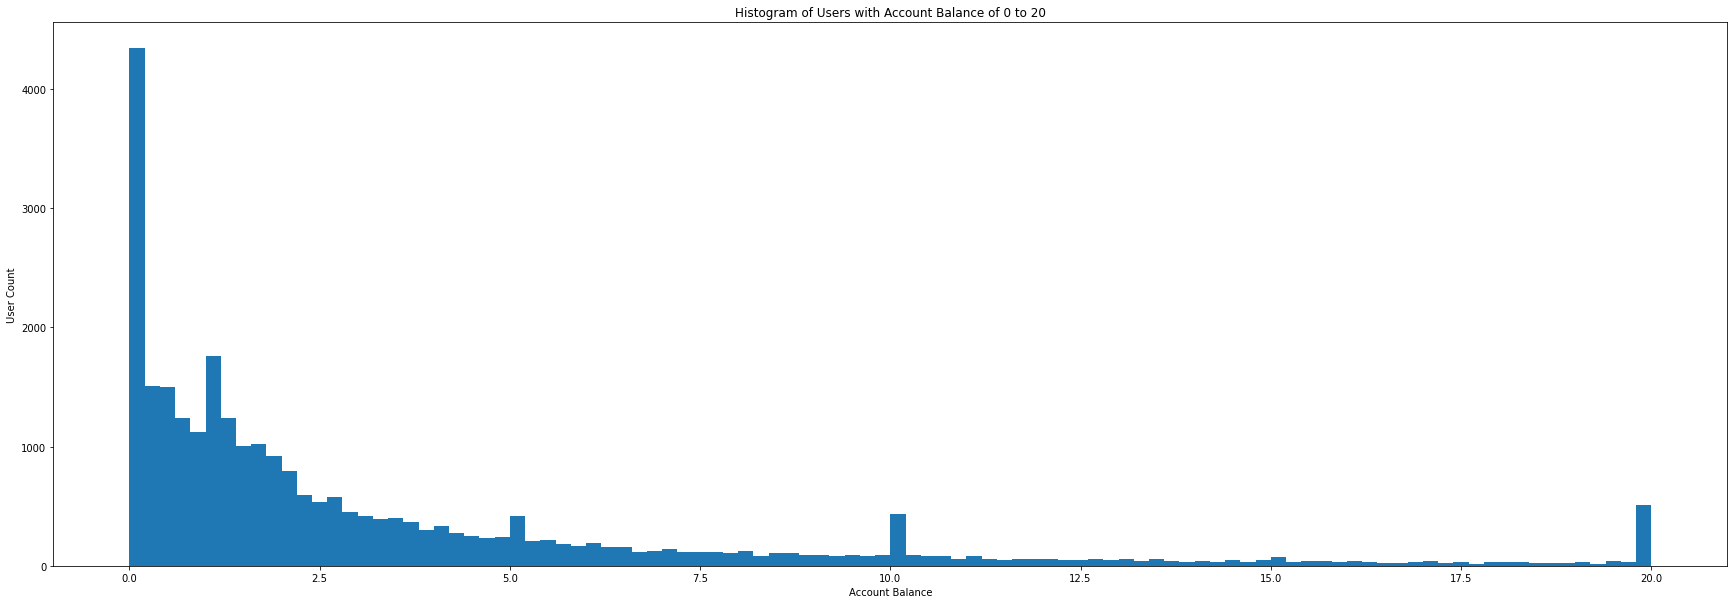

In [63]:
# Plot Histogram of range(0 - 20)

plt.subplots(figsize=(30, 10))
plt.hist(acct_balance["current_balance"], bins=100, range=(0, 20))
plt.title("Histogram of Users with Account Balance of 0 to 20")
plt.xlabel("Account Balance")
plt.ylabel("User Count")
plt.show()

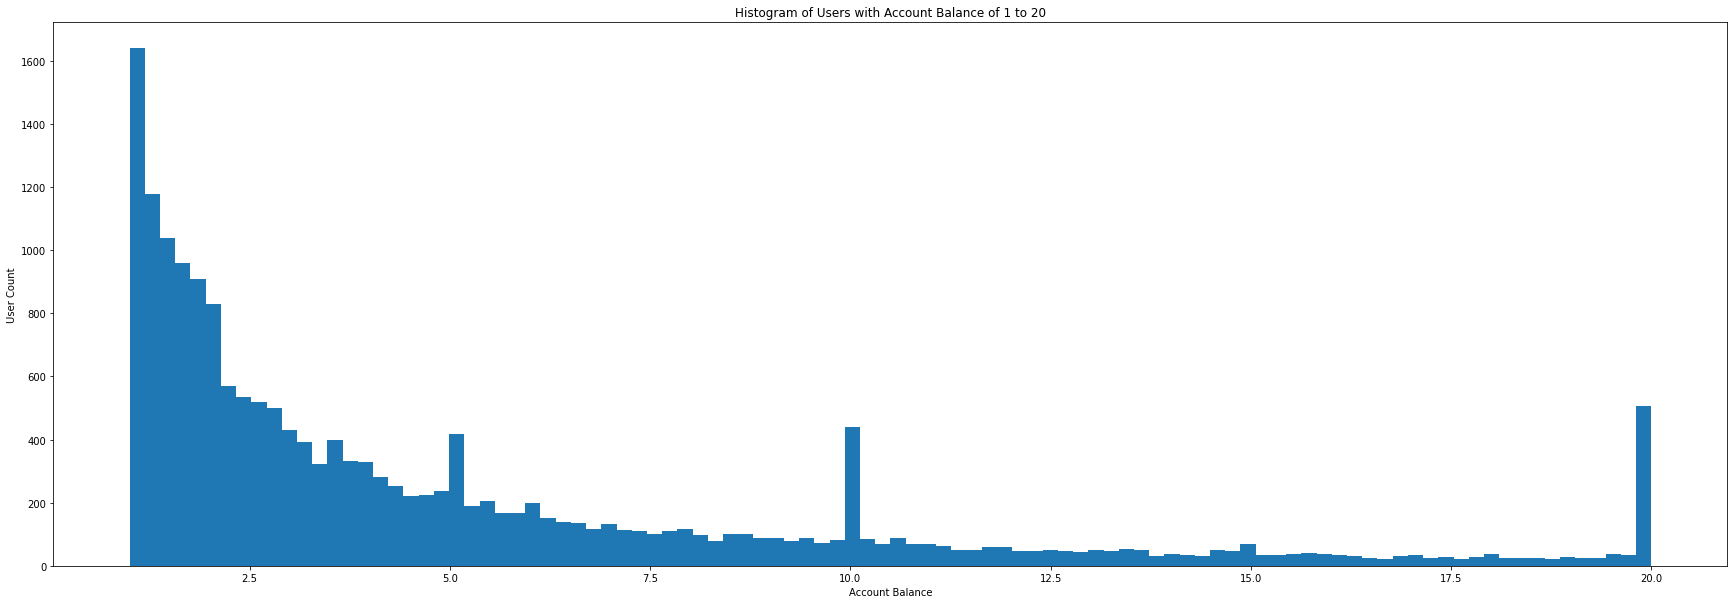

In [64]:
# Plot Histogram of range(1 - 20)

plt.subplots(figsize=(30, 10))
plt.hist(acct_balance["current_balance"], bins=100, range=(1, 20))
plt.title("Histogram of Users with Account Balance of 1 to 20")
plt.xlabel("Account Balance")
plt.ylabel("User Count")
plt.show()

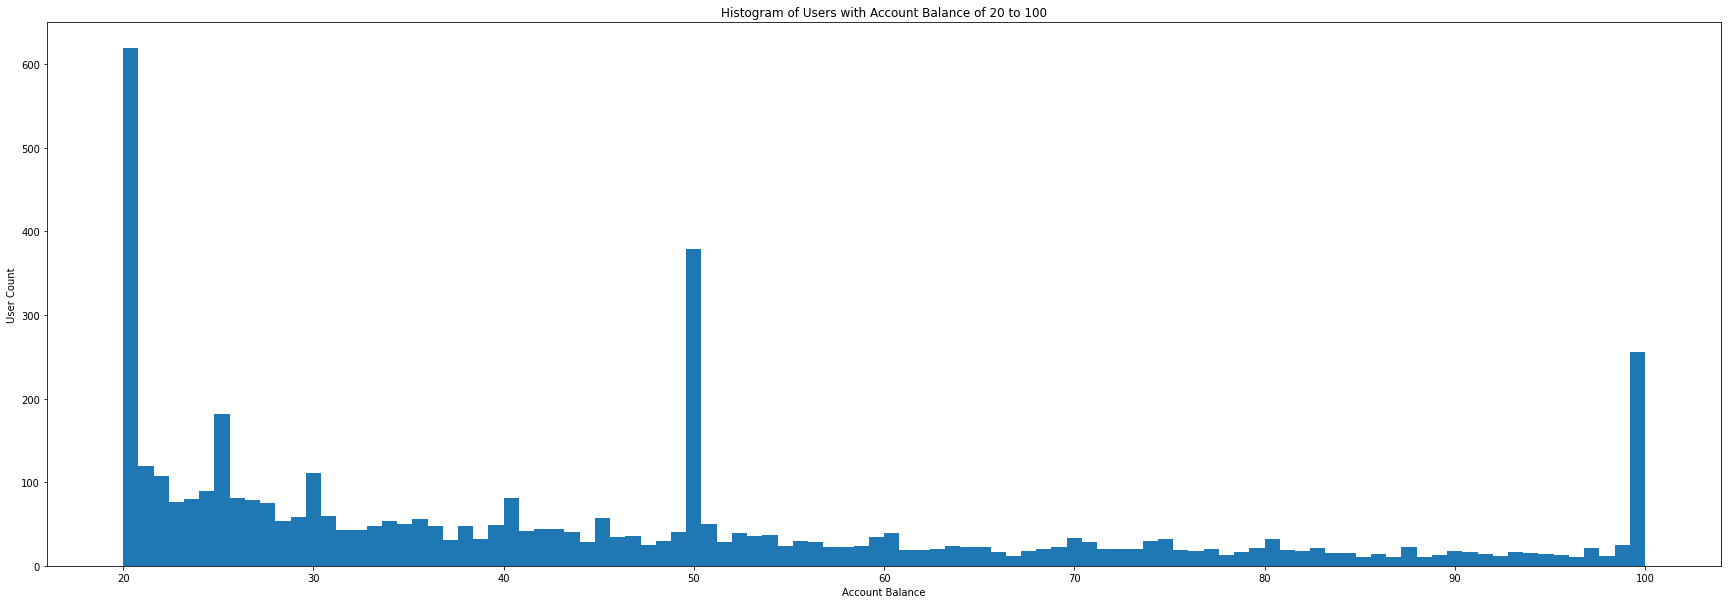

In [65]:
# Plot Histogram of range(20 - 100)

plt.subplots(figsize=(30, 10))
plt.hist(acct_balance["current_balance"], bins=100, range=(20, 100))
plt.title("Histogram of Users with Account Balance of 20 to 100")
plt.xlabel("Account Balance")
plt.ylabel("User Count")
plt.show()

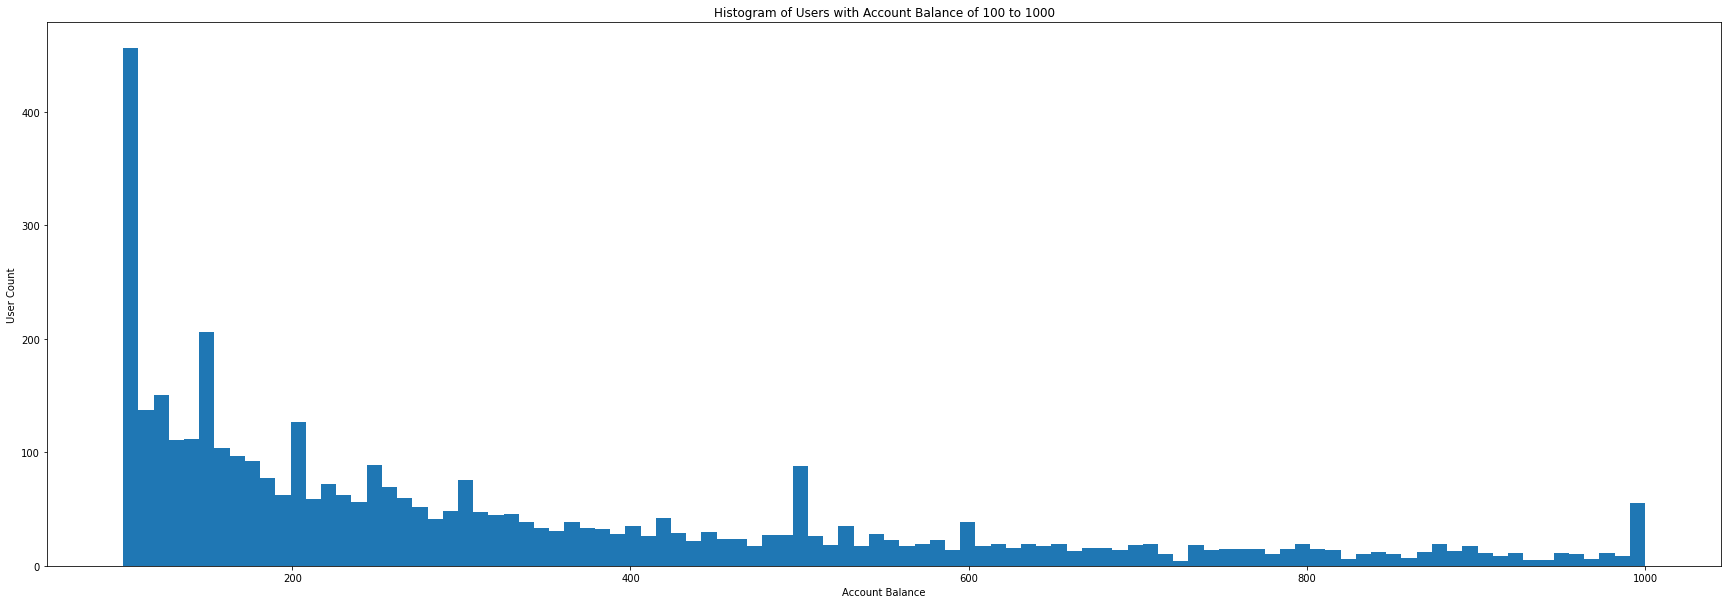

In [69]:
# Plot Histogram of range(100 - 1000)

plt.subplots(figsize=(30, 10))
plt.hist(acct_balance["current_balance"], bins=100, range=(100, 1000))
plt.title("Histogram of Users with Account Balance of 100 to 1000")
plt.xlabel("Account Balance")
plt.ylabel("User Count")
plt.show()

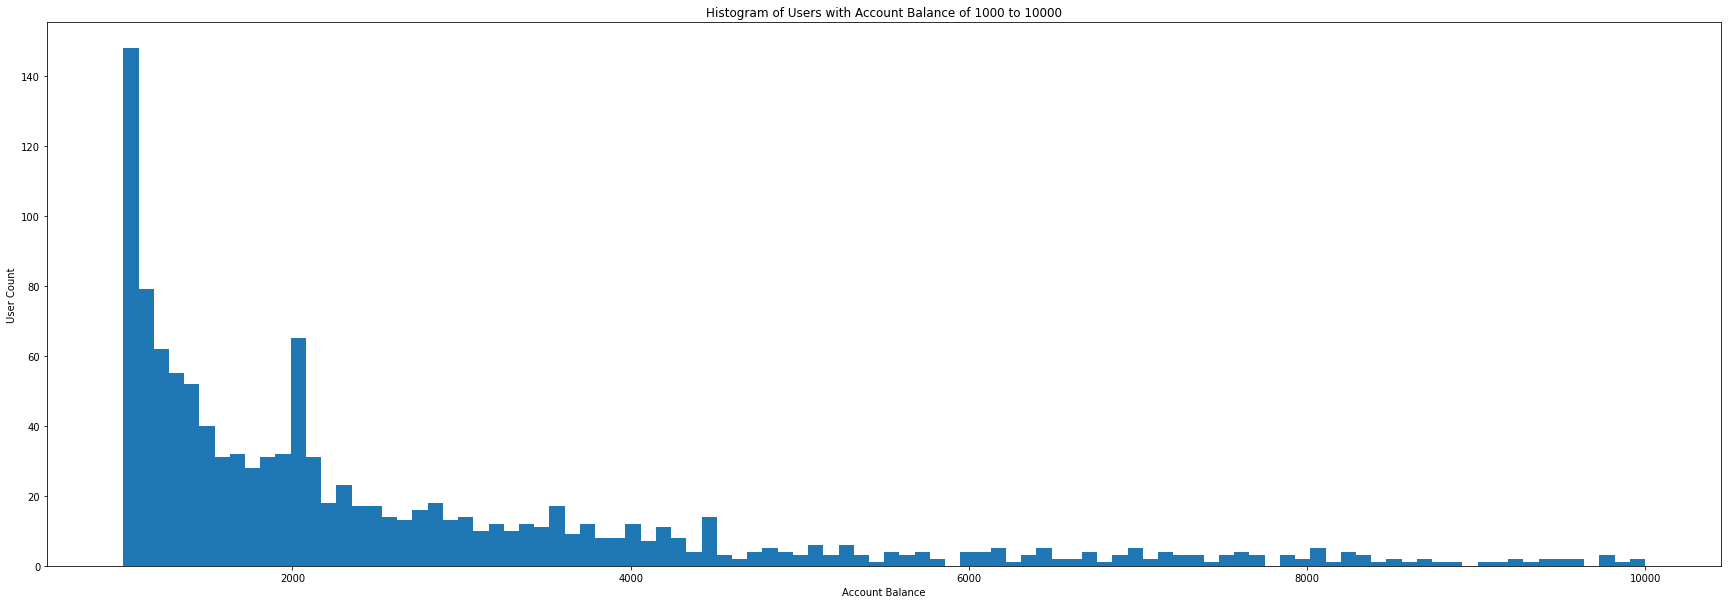

In [70]:
# Plot Histogram of range(1000 - 10000)

plt.subplots(figsize=(30, 10))
plt.hist(acct_balance["current_balance"], bins=100, range=(1000, 10000))
plt.title("Histogram of Users with Account Balance of 1000 to 10000")
plt.xlabel("Account Balance")
plt.ylabel("User Count")
plt.show()

Observations:  
Analyses is based on open accounts 
> 1. The distribution of account balances is heavily right-skewed as expected.
> 2. 8% of users with open accounts have account balance of $0. Around 60% users with open accounts have $0 to $20; 14.8% users have $20 to $100; 15.1% users have $100 to $2000. And 2.2% users have over $2000.
> 3. Number of users spikes around where account balances are multiples of '10'.


### Account Closure by Week

The link to query on User with Account Closed:
<br> https://metabase-main.tech26.us/question/1925-user-with-account-closed?period=week

Observations:
> 1. Major hike in number of users who have accounts closed in July, end of August and end of September due to several remediation efforts.
> 2. During other times majority of the accounts closed has been flagged "fraud".
